In [1]:
# Required inputs
from prepare import calc_rmse
import prepare
import acquire

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

# hypothesis testing
from scipy import stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px

In [2]:
df = acquire.get_zillow_2017()
df = prepare.prepare_zillow(df) #Get and clean data
train, X_train, y_train, X_val, y_val, X_test, y_test = prepare.split_data(df,'value') #Split data, create dummies

# Loop through X sets and apply new_features function (bb_sqft, hsf_lsf)
X_sets = [X_train,X_val,X_test]
for x in X_sets:
    x = prepare.new_features(x)

# Project Overview and Goals

Zillow releases data on their home listings and sales. This project takes data from zillow transactions in 2017 and 3 different fips (6037 - Los Angelos County, 6059 - Orange County, 6111 - Ventura County) to attempt to determine what drives home value.

Explore drivers of home value. Create a model to predict home value.

### Four Questions:  
1. Are newer houses worth more?
2. Does increasing the amount of beds and baths per squarefeet change the value?
3. Does increasing lot size increase value?
4. Does the percentage of house sq ft per lot sq ft change the value?

# Are newer houses worth more?  
Continuous vs continous = pearson R, scatter

Text(0, 0.5, 'Value')

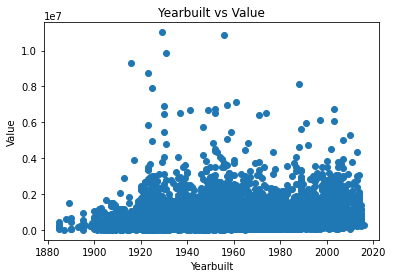

In [3]:
# Create Scatter Plot
plt.scatter(train.yearbuilt,train.value)
plt.title('Yearbuilt vs Value')
plt.xlabel('Yearbuilt')
plt.ylabel('Value')

In [4]:
# Calculate spearmanr 
corr, p = stats.spearmanr(train.yearbuilt, train.value)
corr, p

(0.2494460643952508, 0.0)

### It's hard to see correlation in the scatter plot but using pearsonsr confirms a relationship

# Does increasing the amount of beds and baths per squarefeet change the value?

In [5]:
train['bb_sqft'] = (train['bed']+train['bath'])/train['squarefeet'] #Create new feature

Text(0, 0.5, 'Value')

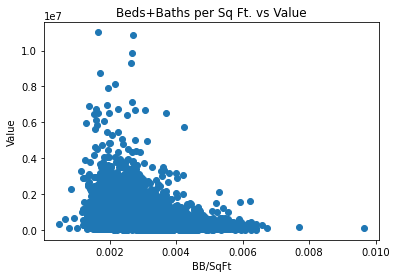

In [7]:
# Create Scatter Plot
plt.scatter(train.bb_sqft,train.value)
plt.title('Beds+Baths per Sq Ft. vs Value')
plt.xlabel('BB/SqFt')
plt.ylabel('Value')

In [8]:
# Calculate spearmanr 
corr, p = stats.spearmanr(train.bb_sqft, train.value)
corr, p

(-0.37342664089501715, 0.0)

### The plot looks like there might be a negative correlation between bb/sqft and value. Pearson R confirms this is the case

# Does increasing lot size increase value?

Text(0, 0.5, 'Value')

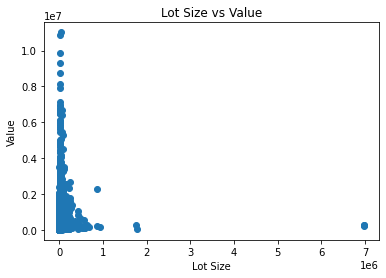

In [9]:
# Create Scatter Plot
plt.scatter(train.lotsquarefeet,train.value)
plt.title('Lot Size vs Value')
plt.xlabel('Lot Size')
plt.ylabel('Value')

In [10]:
# Calculate spearmanr 
alpha = .05
corr, p = stats.spearmanr(train.lotsquarefeet, train.value)
print(f'alpha: {alpha}')
print(f'p: {p/2}')
print('corr is positive and p<alpha so we can say that greater lotsquarefeet increases the value')



alpha: 0.05
p: 1.513770138537716e-93
corr is positive and p<alpha so we can say that greater lotsquarefeet increases the value


# Does the percentage of house sq ft per lot sq ft change the value?

In [11]:
train['hsf_lsf'] = train.squarefeet/train.lotsquarefeet #Create new feature on train set

Text(0, 0.5, 'Value')

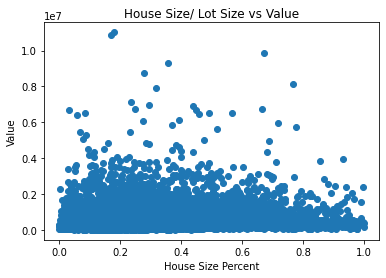

In [12]:
# Create Scatter Plot
plt.scatter(train.hsf_lsf,train.value)
plt.title('House Size/ Lot Size vs Value')
plt.xlabel('House Size Percent')
plt.ylabel('Value')

In [13]:
# Calculate spearmanr 
alpha = .05 
corr, p = stats.spearmanr(train.hsf_lsf, train.value)
corr,p

(0.27481518621093104, 0.0)

Houses that occupy a larger percentage of the lot size are worth more than when lot size is larger and house size smaller

### Summary: All four features are drivers of value  
House Age - beds&baths/sqft - lot size - housesqft to lotsqft

# Let's run some models!

### First let's scale our X_sets

In [14]:
train, validate, test = prepare.scale_minmax(X_train,X_val,X_test) #Scale data 
    

In [15]:
# Establish baseline predictions 
y_train['base_mean'] = round(y_train.value.mean(),1)
y_train['base_median'] = round(y_train.value.median(),1)

# Evaluate baseline models using RMSE - we will use Mean as the baseline
rmse_train_mean = calc_rmse(y_train.value,y_train.base_mean)
rmse_train_median = calc_rmse(y_train.value, y_train.base_median)

# Evaluate baseline on validate test
y_val['baseline'] = round(y_train.value.mean(),1)
baseline_val = calc_rmse(y_val.value,y_val.baseline)

print('RMSE Mean: '),print(rmse_train_mean)
print('\n')
print('RMSE Median: '),print(rmse_train_median)

# Create a dict to store rmse values from our models
mod = ['baseline']
rmse = [rmse_train_mean]
rmse_val = [baseline_val]

RMSE Mean: 
477800.4732868935


RMSE Median: 
488644.68316946016


In [43]:
# Transform our X_train and X_val set into polynomials of range 1-3
pf2 = PolynomialFeatures(degree=2)
X_train_pf2 = pf1.fit_transform(X_train)
X_val_pf2 = pf1.fit_transform(X_val)

pf3 = PolynomialFeatures(degree=3)
X_train_pf3 = pf3.fit_transform(X_train)
X_val_pf3 = pf3.fit_transform(X_val)
X_test_pf3 = pf3.fit_transform(X_test)


In [39]:
def model(ml_model,mod_name,X_train,X_val): #Create model function calculate rmse on train and validate
    '''
    ml_model: ml model
    mod_name: name of the model
    X_train: X dataset
    X_val: X dataset
    '''
    model = ml_model
    model.fit(X_train,y_train.value)
    pred = model.predict(X_train).round(1)
    rmse_train =calc_rmse(y_train.value,pred)
    pred = model.predict(X_val).round(1)
    rmse_validate = calc_rmse(y_val.value,pred)
    
    return rmse_train,rmse_validate, mod_name

In [45]:
def model_test(ml_model,mod_name,X_test): #Create a function to check rmse on test set
    model = ml_model
    model.fit(X_train_pf3,y_train.value)
    pred = model.predict(X_test).round(1)
    rmse_test =calc_rmse(y_test.value,pred)
    
    return rmse_test

In [50]:
# Create all of our models
models= [LinearRegression(),LassoLars(alpha=.1),TweedieRegressor(power=0),TweedieRegressor(power=1)]
mod_name = ['lm','lass','tweedie0','tweedie1']
add_pf = ['_pf2','_pf3']

for m,n in zip(models,mod_name): #Creates models off our reg X_train/val sets
    a,b,c = model(m,n,X_train,X_val)
    mod.append(c) # Append values to our lists
    rmse.append(a)
    rmse_val.append(b)

pfx = [X_train_pf2,X_train_pf3] #Creates models off of our pf1/pf2/pf3 X sets
pfy = [X_val_pf2,X_val_pf3]


for x,y,na in zip(pfx,pfy,add_pf):
    for m,n in zip(models,mod_name):
        name = n+na
        a,b,c = model(m,name,x,y) # Call our function
        mod.append(c) # Append values to our lists
        rmse.append(a)
        rmse_val.append(b)
        
        
results = pd.DataFrame({'model':mod,'rmse_train':rmse,'rmse_val':rmse_val}) # Create df out of lists

In [52]:
results.sort_values('rmse_val').head() # Sort our models by rmse_val

,model,rmse_train,rmse_val
12,tweedie1_pf2,385304.327320,421893.930563
10,lass_pf2,385134.176268,425258.600960
36,tweedie1_pf3,382318.631296,425473.868298
24,tweedie1_pf3,382318.631296,425473.868298
9,lm_pf2,385131.151630,425804.861241


In [ ]:
555441/4

### We run our best model on the test set and receive a RMSE of 378565.84  
Baseline: 555441.06   Model: 421937  Improvement: 176875.22 = 32%

In [46]:
model_test(TweedieRegressor(power=1),'tweedie1',X_test_pf3)

421937.4347901608

# Key findings, Recommendations and Next Steps

House age, more beds and baths per square ft, lot size, and percentage of square ft between the house and lot are all drivers of value. Our model beats the Baseline model by 32% which is significant.  

Recommendations:
While all the variables we looks at seem to be drivers of value, 

Next Steps:  
The next variable I would look at to improve the model would be zip codes and neighborhoods.